In [1]:
from pandas import read_csv

tag = dict([(p,w) for _,p,w in read_csv('../input/train.csv').to_records()]) #tagged
submit = [p for _,p,_ in read_csv('../input/sample_submission.csv').to_records()]
#join   = list(tagged.keys()) + submit
#len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]  # 25361 7960 33321

In [2]:
# 加入测试图像 第一列  mpiotte-standard-w0.99-one.csv

tested = dict([(p,w) for _,p,w in read_csv('./mpiotte-standard-w0.99-one.csv').to_records()])

list(tested.items())[:5],len(tested) #7960

([('00028a005.jpg', 'w_dec7ffd'),
  ('000dcf7d8.jpg', 'w_4132bb8'),
  ('000e7c7df.jpg', 'new_whale'),
  ('0019c34f4.jpg', 'w_c99807e'),
  ('001a4d292.jpg', 'new_whale')],
 7960)

In [3]:
tagged = tag.copy()
tagged.update(tested)
# 训练集 
len(tagged)#33321

33321

In [4]:
join   = list(tagged.keys()) + submit
len(join) #41281

41281

In [5]:
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../input/train/' + p): 
        #print("train")
        return '../input/train/' + p
    if isfile('../input/train_ex/' + p): 
        #print("train_ex")
        return '../input/train_ex/' + p
    if isfile('../input/test/' + p): 
        #print("test")
        return '../input/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(33321,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [6]:
import pickle
import numpy as np
from imagehash import phash
from math import sqrt


def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('./p2h_total.pickle'):
    with open('./p2h_total.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    
    hs = list(h2ps.keys())

    
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
        
    with open('p2h_total.pickle', 'wb') as f: 
        pickle.dump(p2h, f)

len(p2h), list(p2h.items())[:5] #41281

(33321,
 [('0000e88ab.jpg', 'd26698c3271c757c'),
  ('0001f9222.jpg', 'ba8cc231ad489b77'),
  ('00029d126.jpg', 'bbcad234a52d0f0b'),
  ('00050a15a.jpg', 'c09ae7dc09f33a29'),
  ('0005c1ef8.jpg', 'd02f65ba9f74a08a')])

In [7]:
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
len(h2ps),list(h2ps.items())[:5]  #33317 

(33317,
 [('d26698c3271c757c', ['0000e88ab.jpg']),
  ('ba8cc231ad489b77', ['0001f9222.jpg']),
  ('bbcad234a52d0f0b', ['00029d126.jpg']),
  ('c09ae7dc09f33a29', ['00050a15a.jpg']),
  ('d02f65ba9f74a08a', ['0005c1ef8.jpg'])])

In [8]:
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): 
        ax.imshow(img.convert('RGB'))
        plt.show()

for h, ps in h2ps.items():
    if len(ps) > 2:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [9]:
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: 
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [10]:
with open('./rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate

{'2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg',
 'f966c073.jpg'}

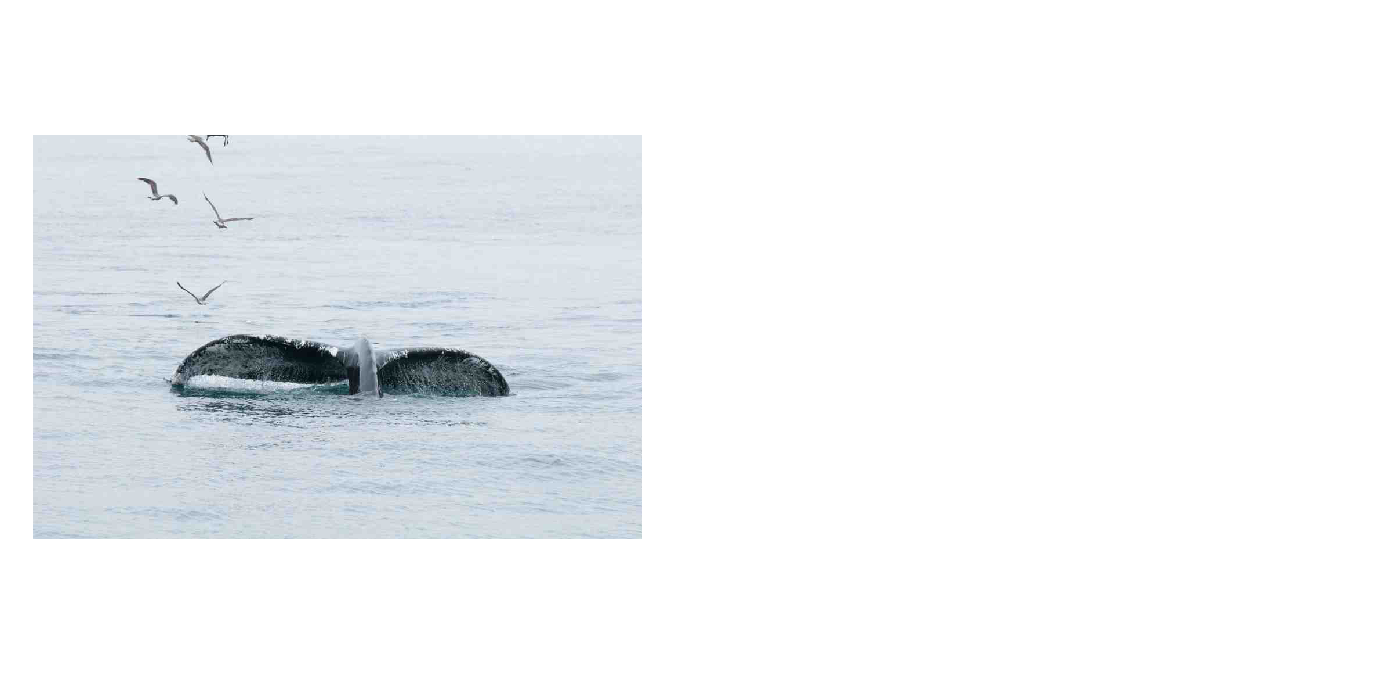

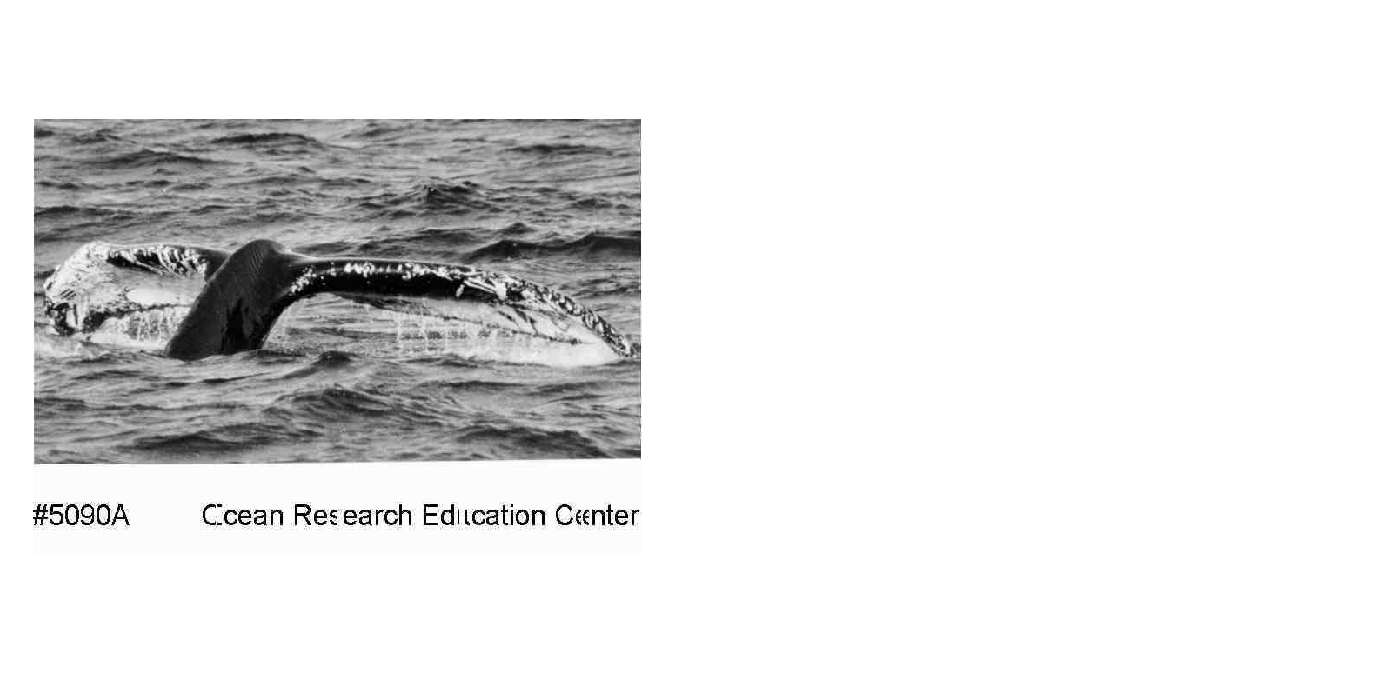

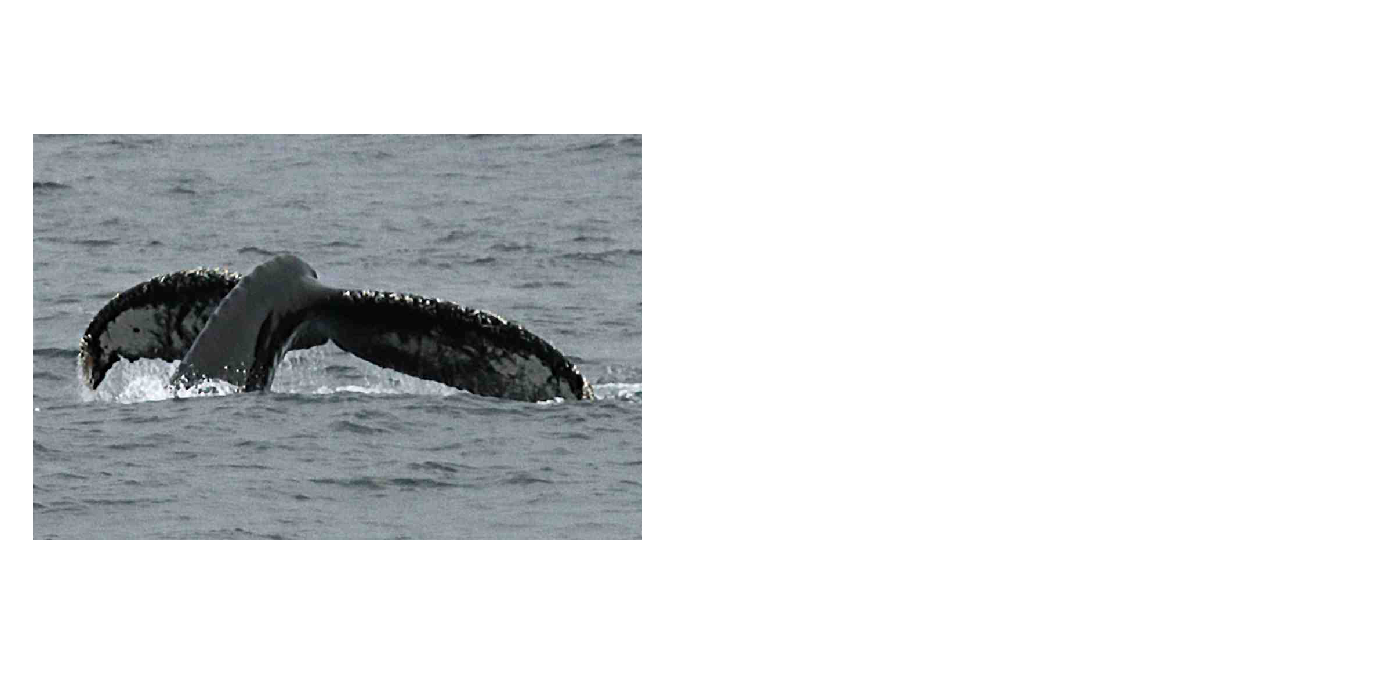

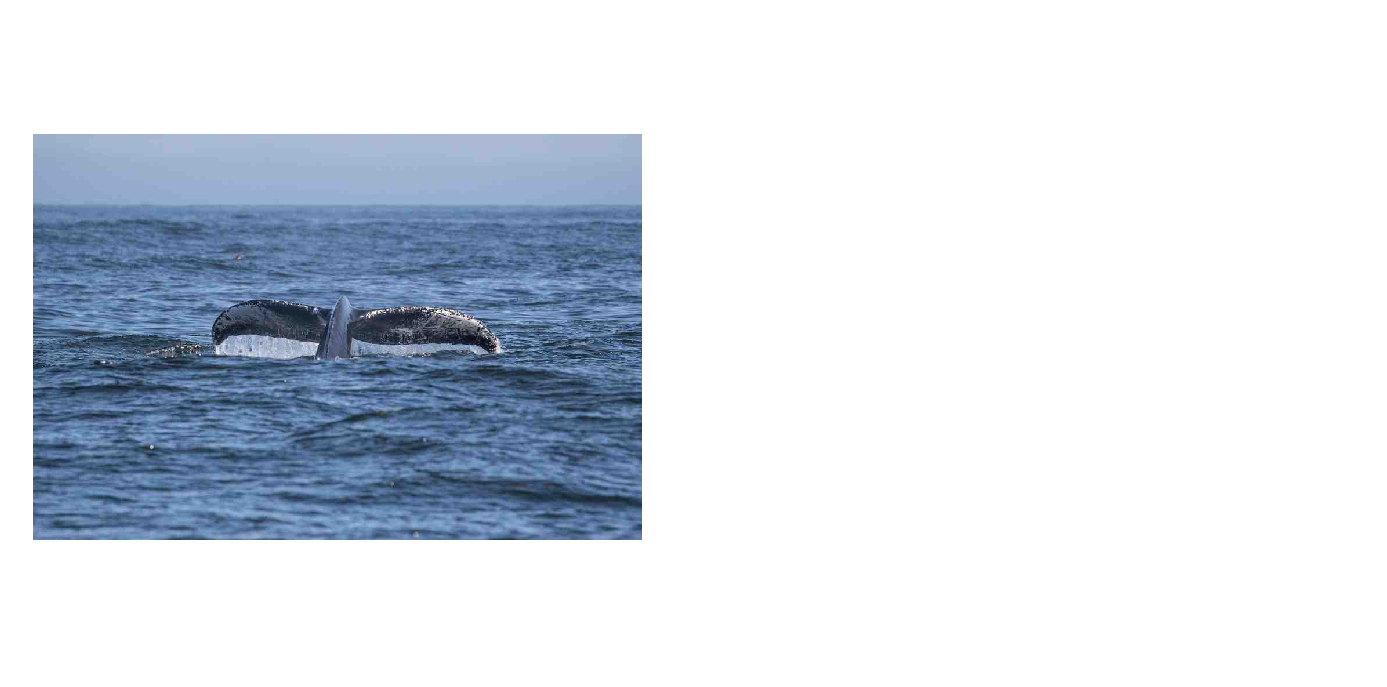

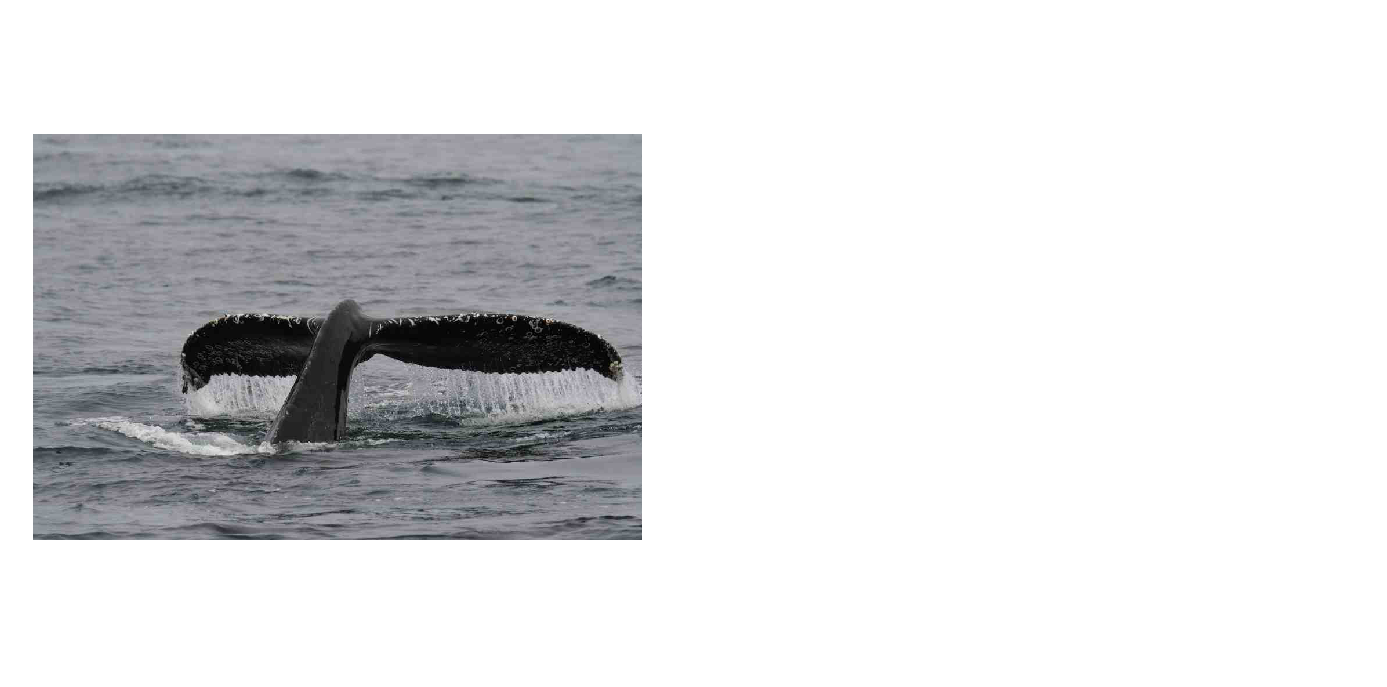

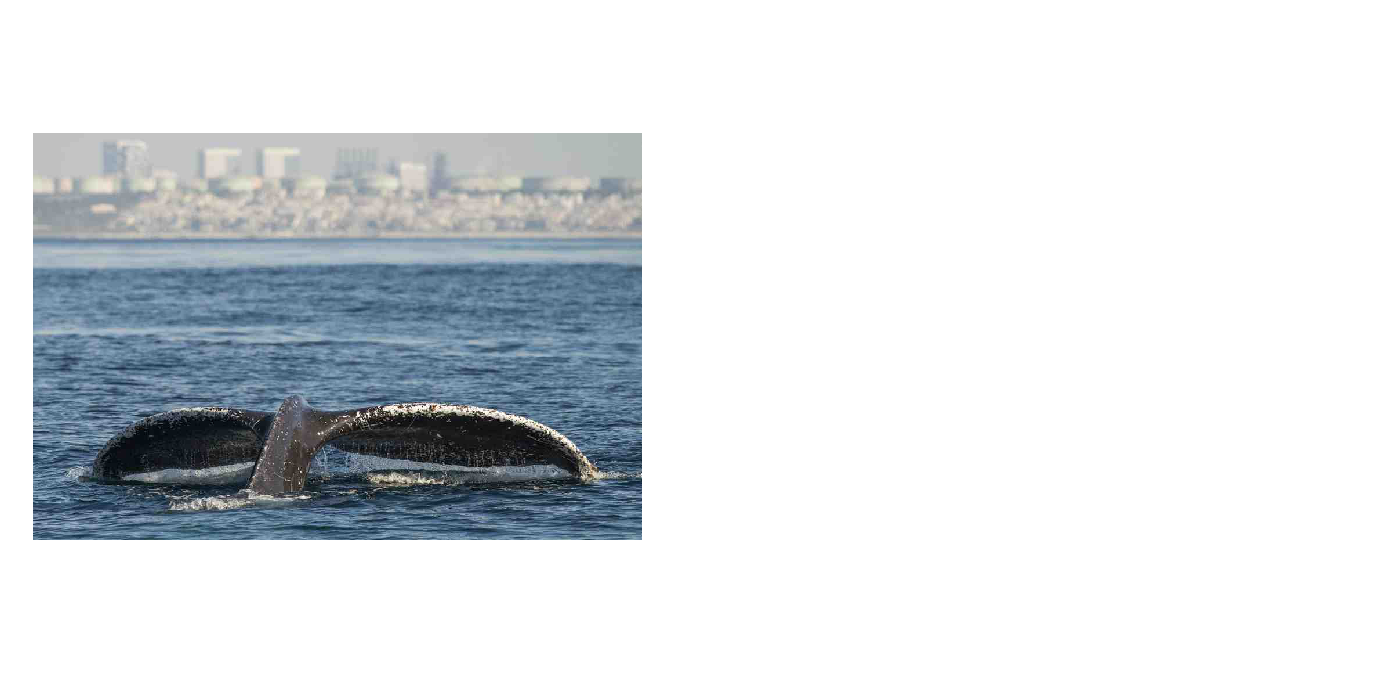

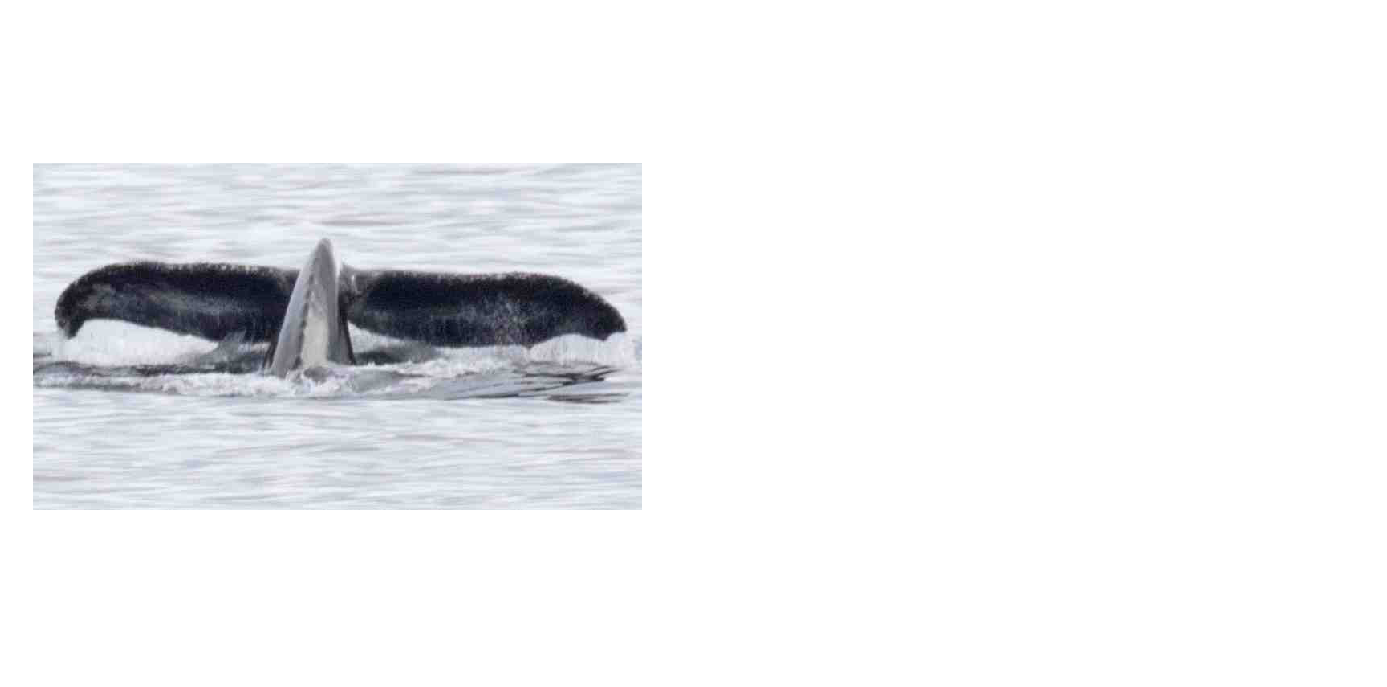

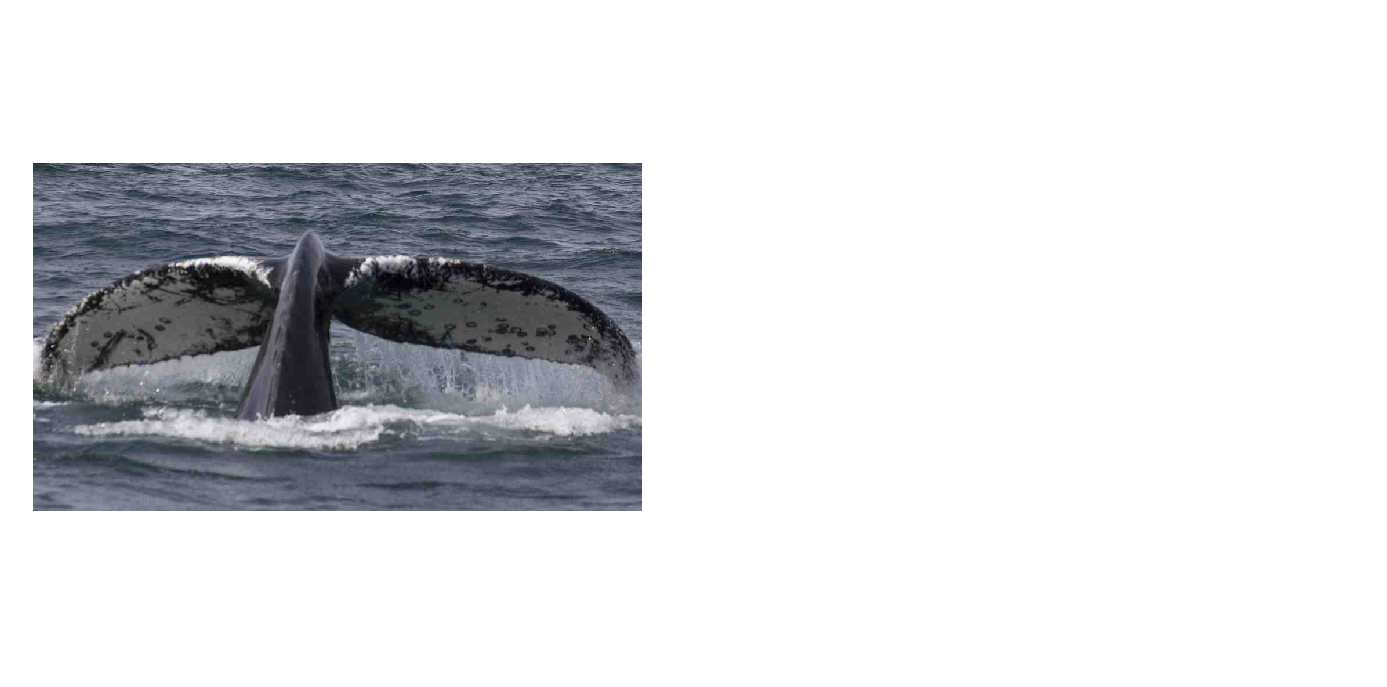

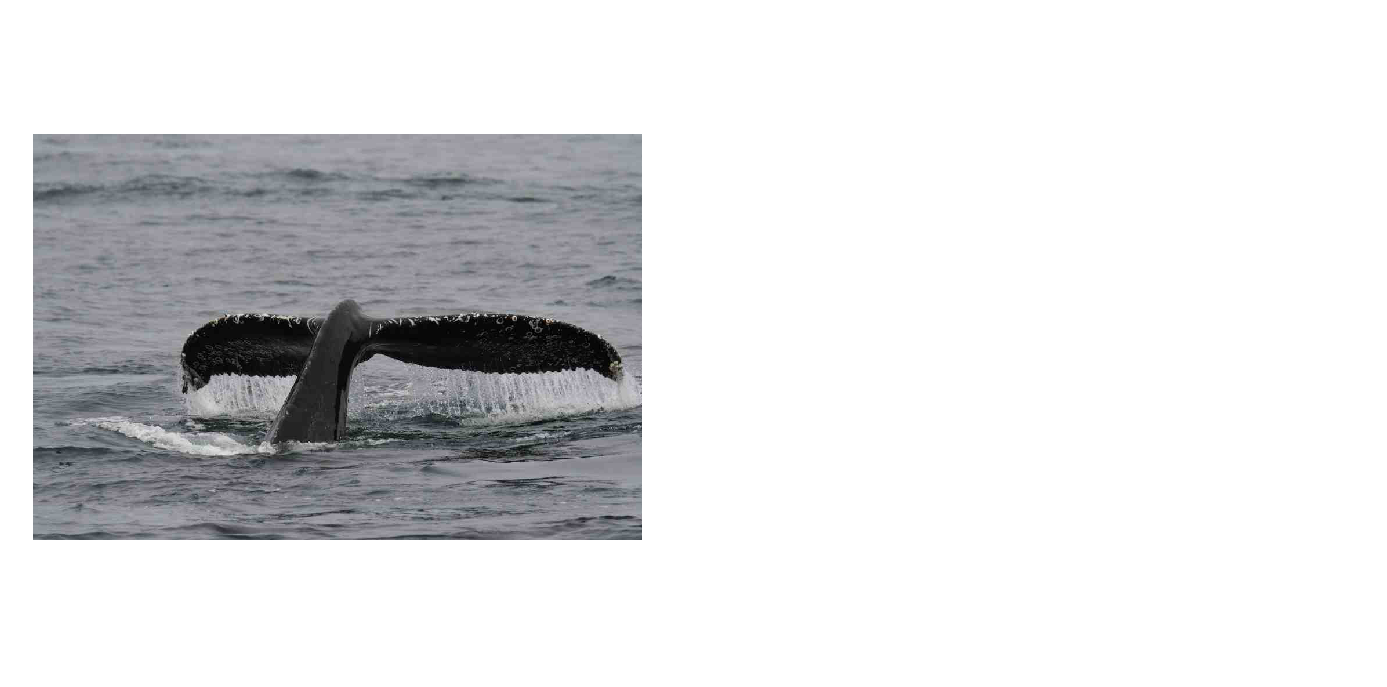

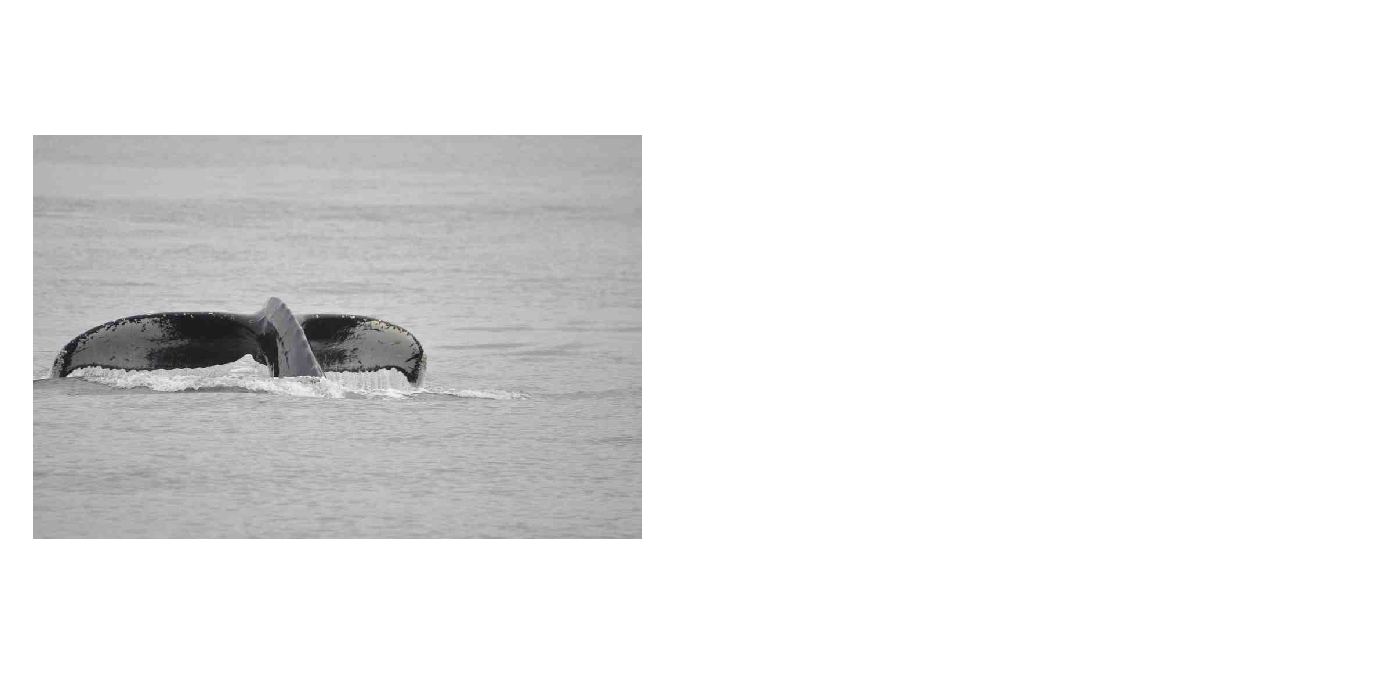

In [11]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))    
    if p in rotate: 
        img = img.rotate(180)
        
    return img

for i in range(len(list(rotate))):
    #print(i) 
    p    = list(rotate)[i]
    imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
    show_whale(imgs)

In [12]:
with open('./bounding-box-new.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('0000e88ab.jpg', (209, 147, 841, 441)),
 ('0001f9222.jpg', (10, 79, 756, 240)),
 ('00029d126.jpg', (30, 21, 1020, 469)),
 ('00050a15a.jpg', (33, 159, 1012, 401)),
 ('0005c1ef8.jpg', (95, 208, 892, 288))]

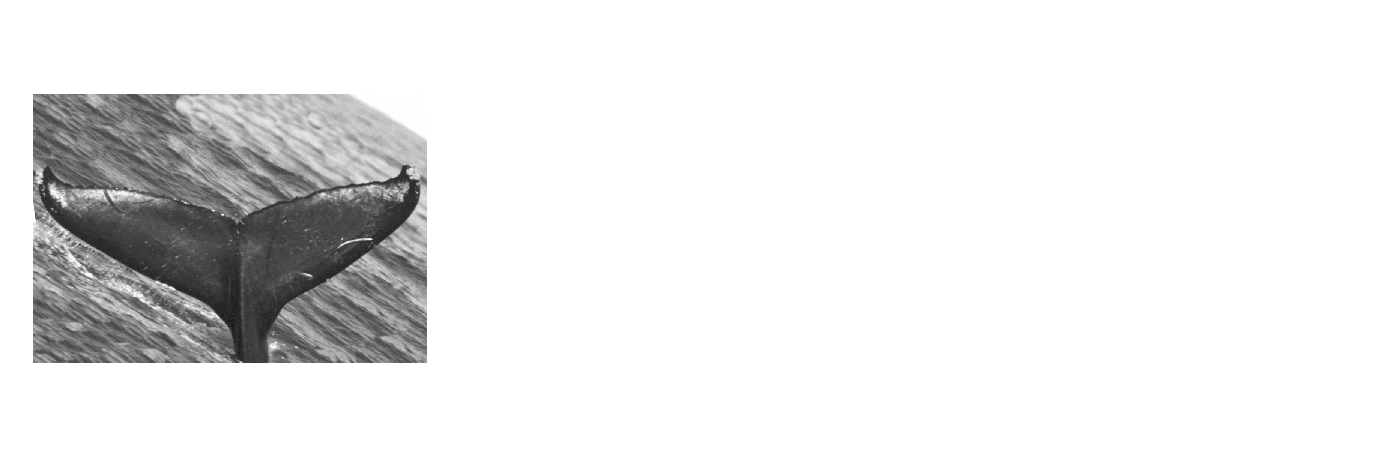

In [13]:
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) 
anisotropy   = 2.15 
crop_margin  = 0.05

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
   
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
   
    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

   
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
   
    return read_cropped_image(p, True)

def read_for_validation(p):
   
    return read_cropped_image(p, False)

p = list(tagged.keys())[312]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [14]:
from keras import backend as K
def matthews_correlation(y_true, y_pred):
  
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [31]:
# 损失
import tensorflow as tf
# 2分类 Dice Loss
def dice_coefficient(y_true_cls, y_pred_cls):
    
    eps = 1e-5
    intersection = tf.reduce_sum(y_true_cls * y_pred_cls )
    union = tf.reduce_sum(y_true_cls ) + tf.reduce_sum(y_pred_cls) + eps
    loss = 1. - (2 * intersection / union)

    return loss

    
# 2 分类 focal loss
def focal_loss(y_true, y_pred):
    gamma=0.75
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
 
    pt_1 = K.clip(pt_1, 1e-3, .999)
    pt_0 = K.clip(pt_0, 1e-3, .999)
 
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def log_dice_loss(y_true, y_pred):
    return - K.log(dice_coefficient(y_true,y_pred))

#Focal Loss + DICE LOSS
def mixedLoss(y_true,y_pred,alpha=0.5):
    return alpha * focal_loss(y_true,y_pred) - K.log(dice_coefficient(y_true,y_pred))



def binary_crossentropy(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

#BCE + DICE LOSS
def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(dice_coefficient(y_true,y_pred))

# WEIGHTED BCE DICE LOSS
def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_single_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_dice_loss(y_true, y_pred, weight)
    return loss

# weighted_log_dice_loss
def weighted_log_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = - K.log(weighted_dice_loss(y_true, y_pred, weight))
    return loss

def weighted_focal_dice_loss(y_true, y_pred,alpha=1):
    
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_dice_loss(y_true, y_pred, weight) + alpha*focal_loss(y_true, y_pred)
    return loss

In [33]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) 
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)
    y = Add()([x,y]) 
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

   
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
   
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')
    
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    #model.compile(optim, loss=mixedLoss, metrics=[matthews_correlation, 'acc']) 
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)

In [19]:
branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 192, 192, 64) 5248        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 96, 96, 64)   0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 96, 96, 64)   256         max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_59 

In [20]:
head_model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 512)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 512)          0           input_7[0][0]                    
          

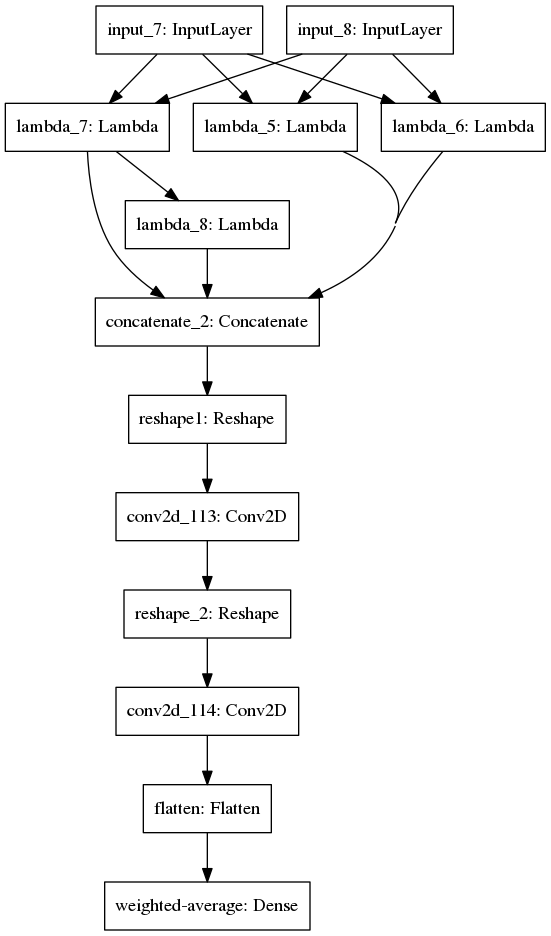

In [21]:
from keras.utils import plot_model
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

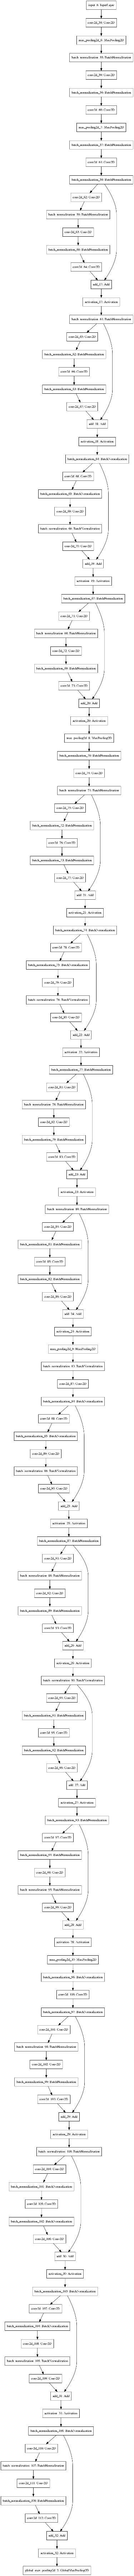

In [22]:
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])

In [17]:
with open('./exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   
len(exclude)

34

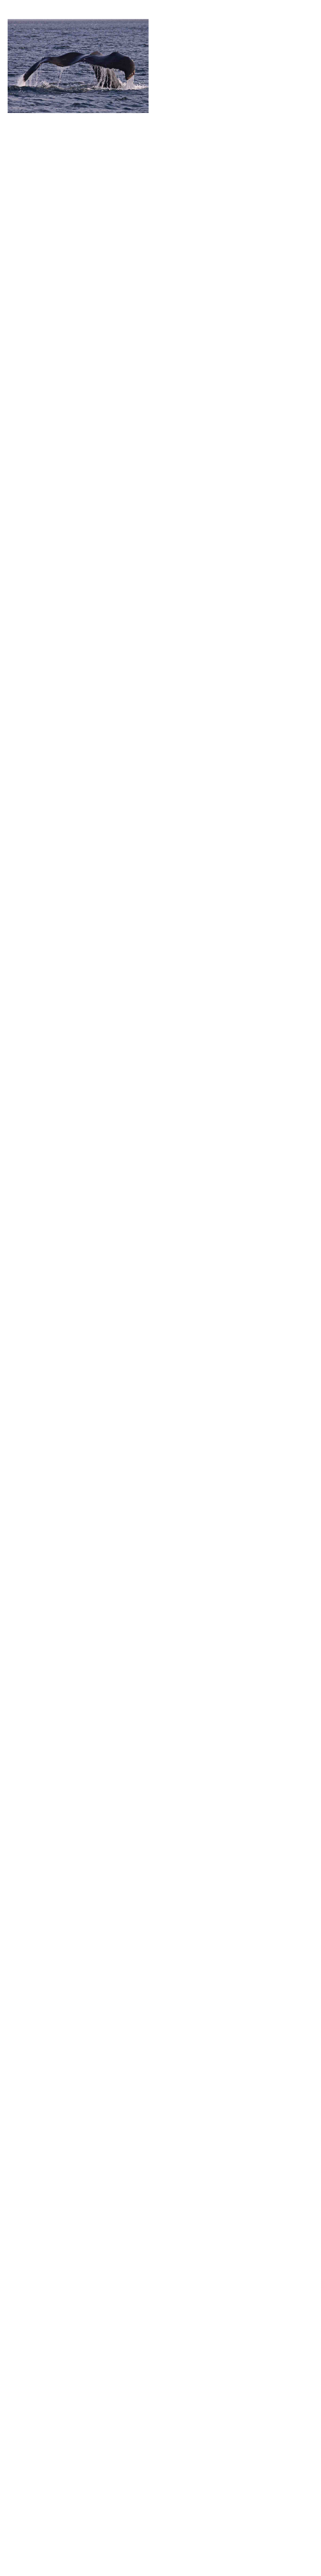

In [18]:
imgs=[]
for p in exclude:
    img = read_raw_image(p)
    imgs.append(img)
    
#len(imgs)    
show_whale(imgs, per_row=2)

In [19]:
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: 
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

20769

In [20]:
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: 
        if h2p[h] in exclude:
            print(h)
        else:
            w = ws[0]
            if w not in w2hs: w2hs[w] = []
            if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

5004

In [21]:
train = [] 
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {} 
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} 
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(20167, 4402)

In [22]:
from keras.utils import Sequence


try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
       
        super(TrainingData, self).__init__()
        self.score      = -score 
        self.steps      = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0 
        self.on_epoch_end()
    def __getitem__(self, index):
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size  = end - start
        assert size > 0
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        c     = np.zeros((size,1), dtype=K.floatx())
        j     = start//2
        for i in range(0, size, 2):
            a[i,  :,:,:] = read_for_training(self.match[j][0])
            b[i,  :,:,:] = read_for_training(self.match[j][1])
            c[i,  0    ] = 1 
            a[i+1,:,:,:] = read_for_training(self.unmatch[j][0])
            b[i+1,:,:,:] = read_for_training(self.unmatch[j][1])
            c[i+1,0    ] = 0 
            j           += 1
        return [a,b],c
    def on_epoch_end(self):
        if self.steps <= 0: return 
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) 
        y = np.arange(len(x),dtype=np.int32)

        
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts,d): self.match.append(ab)

       
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

       
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1)//self.batch_size

Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment


In [23]:
score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

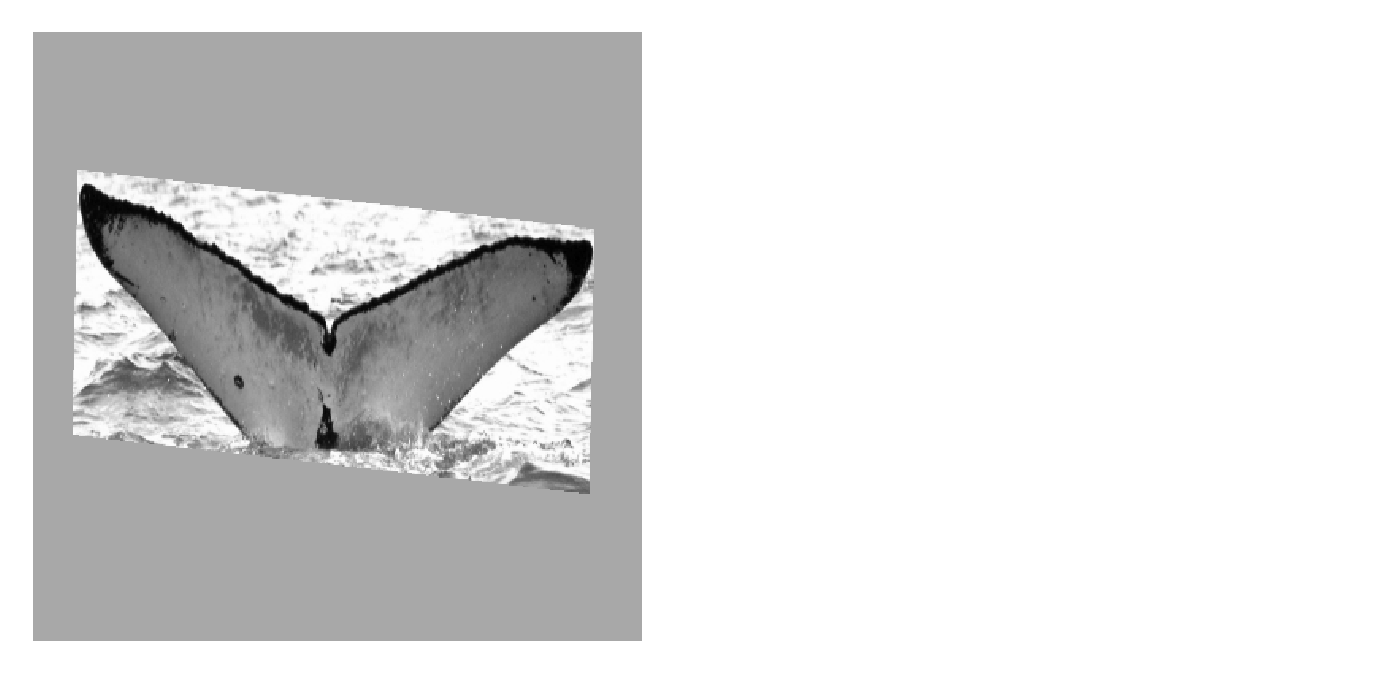

In [24]:
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

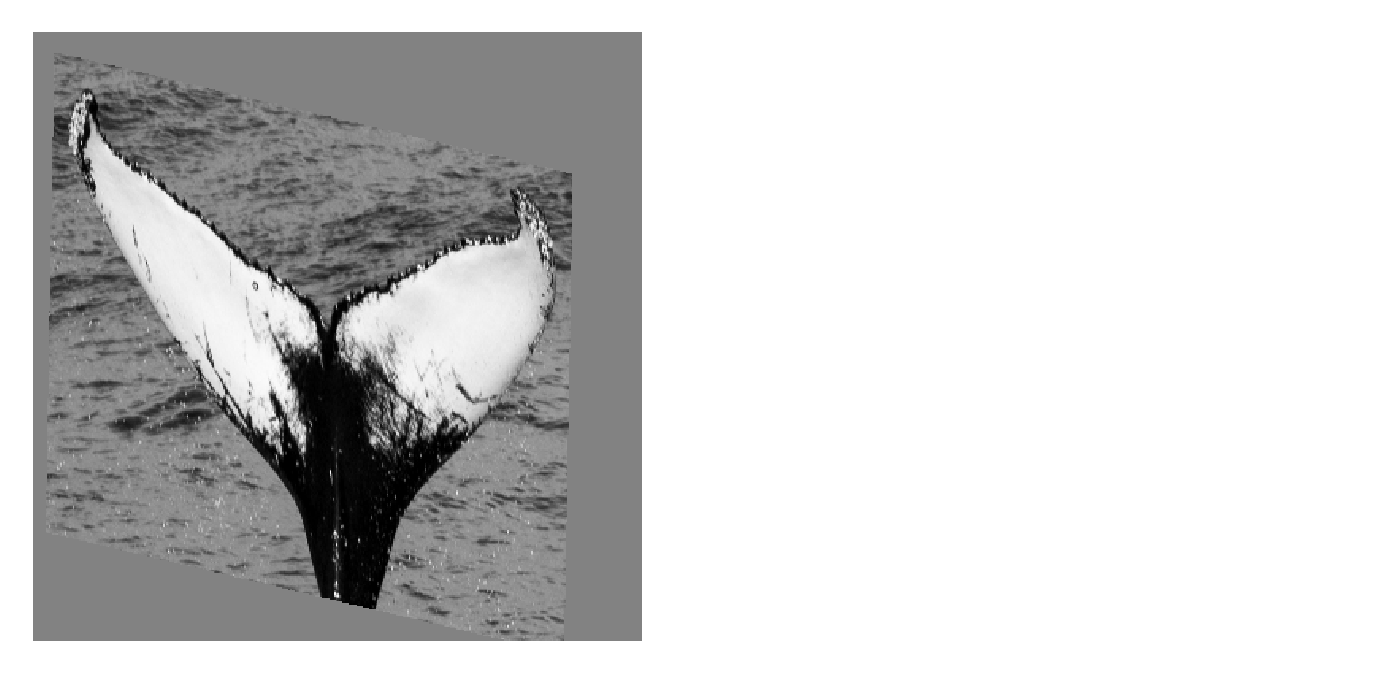

In [25]:
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

In [26]:
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data       = data
        self.batch_size = batch_size
        self.verbose    = verbose
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Features')
    def __getitem__(self, index):
        start = self.batch_size*index
        size  = min(len(self.data) - start, self.batch_size)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i,:,:,:] = read_for_validation(self.data[start + i])
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a
    def __len__(self):
        return (len(self.data) + self.batch_size - 1)//self.batch_size


class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x          = x
        self.y          = y
        self.batch_size = batch_size
        self.verbose    = verbose
        if y is None:
            self.y           = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0],1)
        else:
            self.iy, self.ix = np.indices((y.shape[0],x.shape[0]))
            self.ix          = self.ix.reshape((self.ix.size,))
            self.iy          = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1)//self.batch_size
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Scores')
    def __getitem__(self, index):
        start = index*self.batch_size
        end   = min(start + self.batch_size, len(self.ix))
        a     = self.y[self.iy[start:end],:]
        b     = self.x[self.ix[start:end],:]
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a,b]
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1)//self.batch_size

In [27]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
   
    if y is None:
       
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
   
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    
    global w2ts, t2i, steps, features, score, histories
    
    
    random.shuffle(train)
    
  
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

   
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    
    features, score = compute_score()
    
   
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),#32
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step
    
    
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [28]:
model_name = 'mpiotte-standard'
histories  = []
steps      = 0

In [29]:
import gzip

def prepare_submission(threshold, filename):
    
    vtop  = 0
    vhigh = 0
    pos   = [0,0,0,0,0,0]
    with gzip.open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i,p in enumerate(tqdm_notebook(submit)):
            t = []
            s = set()
            a = score[i,:]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n') #5
    return vtop,vhigh,pos


In [34]:
if isfile('./mpiotte-standard-total-445.model'):
    tmp = keras.models.load_model('./mpiotte-standard-total-445.model')
    model.set_weights(tmp.get_weights())
    print("model achieve")
    
    h2ws = {}
    # 训练集
    for p,w in tagged.items():
        if w != new_whale: 
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

   
    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    
    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)
    #print('score:',score)

   
    prepare_submission(0.92, 'mpiotte-standard-w0.92-total-445.csv.gz')
 

ValueError: Unknown loss function:mixedLoss

In [ ]:
if isfile('./mpiotte-standard-total-450.model'):
    tmp = keras.models.load_model('./mpiotte-standard-total-450.model')
    model.set_weights(tmp.get_weights())
    print("model achieve")
    
    h2ws = {}
    # 训练集
    for p,w in tagged.items():
        if w != new_whale: 
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

   
    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    
    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)
    #print('score:',score)

   
    prepare_submission(0.92, 'mpiotte-standard-w0.92-total-450.csv.gz')
 

In [ ]:
if isfile('./mpiotte-standard-total-455.model'):
    tmp = keras.models.load_model('./mpiotte-standard-total-455.model')
    model.set_weights(tmp.get_weights())
    print("model achieve")
    
    h2ws = {}
    # 训练集
    for p,w in tagged.items():
        if w != new_whale: 
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

   
    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    
    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)
    #print('score:',score)

   
    prepare_submission(0.92, 'mpiotte-standard-w0.92-total-455.csv.gz')
 

In [ ]:
if isfile('./mpiotte-standard.model'):
    tmp = keras.models.load_model('./mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
    print("model achieve")
    
else:
    """
    # epoch -> 10
    make_steps(10, 1000)
    model.save('mpiotte-standard-10.model')
    ampl = 100.0
    for _ in range(10):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100**-0.1*ampl)
    model.save('mpiotte-standard-60.model')
    
    # epoch -> 150
    for _ in range(18): make_steps(5, 1.0)
    model.save('mpiotte-standard-150.model')
    # epoch -> 200
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
    model.save('mpiotte-standard-200.model')
    # epoch -> 240
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    model.save('mpiotte-standard-240.model')
    # epoch -> 250
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    model.save('mpiotte-standard-250.model')
    """
    """
       
    # epoch -> 240
    set_lr(model, 4e-5)
    start = 205
    for _ in range(8): 
        print("start:",start)
        make_steps(5, 0.25)
        start = start+5
        
        model.save('mpiotte-standard-'+str(start)+'.model')
    
    # epoch -> 300
    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5,0.0002)
    model.set_weights(weights)
    for _ in range(10): make_steps(5, 1.0)
    model.save('mpiotte-standard-300.model')
    # epoch -> 350
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5) 
    model.save('mpiotte-standard-350.model') 
    """
    
    tmp = keras.models.load_model('./mpiotte-standard-total-440.model')
    model.set_weights(tmp.get_weights())
    print("mpiotte-standard-total-440 success")
    
    """
    # epoch -> 440
    start = 400
    set_lr(model, 5e-6)#1e-5
    for _ in range(8): 
        #print("start:",start)
        make_steps(5, 0.25)
        start = start+5      
        model.save('mpiotte-standard-new-'+str(start)+'.model')       
    """
    
    # epoch -> 490
    start = 455
    set_lr(model, 1e-5)
    for _ in range(10): 
        #print("start:",start)
        make_steps(5, 0.25)
        start = start+5      
        model.save('mpiotte-standard-total-'+str(start)+'.model')
    
    
    #for _ in range(8): make_steps(5, 0.25)
    #model.save('mpiotte-standard-390.model')   
    # epoch -> 400
   # set_lr(model, 1e-5)
   # for _ in range(2): make_steps(5, 0.25)
  #  model.save('mpiotte-standard-400.model')
  #  model.save('mpiotte-standard.model')

mpiotte-standard-total-440 success



5 1e-05 0.0018717956



10 1e-05 0.0012635849


In [ ]:
with open('./bootstrap.pickle', 'rb') as f:
    bootstrap = pickle.load(f)
len(bootstrap), list(bootstrap.items())[:5]

In [ ]:
w = head_model.layers[-1].get_weights()[0]
w = w.flatten().tolist()
w = sorted(w)
fig, axes = plt.subplots(1,1)
axes.bar(range(len(w)), w)
plt.show()

In [ ]:
_, _, tmp_model = build_model(64e-5,0, activation='linear')
tmp_model.set_weights(head_model.get_weights())

In [ ]:
a = np.ones((21*21,512),dtype=K.floatx())
b = np.ones((21*21,512),dtype=K.floatx())
for i in range(21):
    for j in range(21):
        a[21*i + j] *= float(i)/10.0
        b[21*i + j] *= float(j)/10.0
x    = np.arange(0.0, 2.01, 0.1, dtype=K.floatx())
x, y = np.meshgrid(x, x)
z    = tmp_model.predict([a,b], verbose=0).reshape((21,21))
x.shape, y.shape, z.shape

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.show()

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
fig = plt.figure()
ax = fig.add_subplot(111)
cf = ax.contourf(x, y, z, levels=levels, cmap=cm.coolwarm)
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter

def show_filter(filter, blur):
    np.random.seed(1)
    noise   = 0.1 
    step    = 1 
    
    
    inp     = branch_model.layers[0].get_input_at(0)
    loss    = K.mean(branch_model.layers[-3].output[0,2:4,2:4,filter]) 
    grads   = K.gradients(loss, inp)[0]
    grads  /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    iterate = K.function([inp],[grads])
    img     = (np.random.random(img_shape) -0.5)*noise
    img     = np.expand_dims(img, 0)

   
    for i in range(200):
        grads_value = iterate([img])[0]
        
        img = gaussian_filter(img + grads_value*step, sigma=blur)

  
    avg  = np.mean(img)
    std  = sqrt(np.mean((img - avg)**2))
    low  = avg - 5*std
    high = avg + 5*std
    return array_to_img(np.minimum(high, np.maximum(low, img))[0])


show_whale([show_filter(i, 0.5) for i in tqdm_notebook(range(25))], per_row=5)